# Advanced Lane finding project


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


### Camera Calibration

There are a total of 20 images provided in this project for camera calibration.Let's look at one of the image.

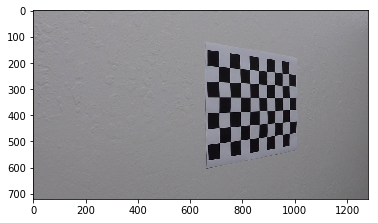

In [2]:
test_calibration = cv2.imread('camera_cal/calibration8.jpg')
test_calibration = cv2.cvtColor(test_calibration,cv2.COLOR_BGR2RGB)
plt.imshow(test_calibration)
plt.show()

We can see that there are 9 corners in x row wise and 6 columns column wise. I will use the below function `get_imagepoints()` to read all calibration images using glob and find the object points and image points for all the images.
Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [3]:
def get_imagepoints():
    '''
    This function returns the list of object points and image points for chessboard calibration images
    which have 9x6 corners
    '''
    # prepare object points
    objp = np.zeros((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints,imgpoints


In [4]:
objpoints,imgpoints = get_imagepoints()

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function

In [5]:
def calibration(input_image,objpoints,imgpoints):
    '''
    Input Params: image,objpoints(list) and image points(list) obtained from cv2.findChessboardCorners
    Output: camera matrix and distortion coefficients
    '''
    img_size = (input_image.shape[1], input_image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx,dist
    

def distortion_correction(input_image,mtx,dist):
    '''
    Input Params : Distorted Image,camera matrix and distortion coefficients
    Output: Undistorted Image
    '''
    dst = cv2.undistort(input_image, mtx, dist, None, mtx)
    return dst


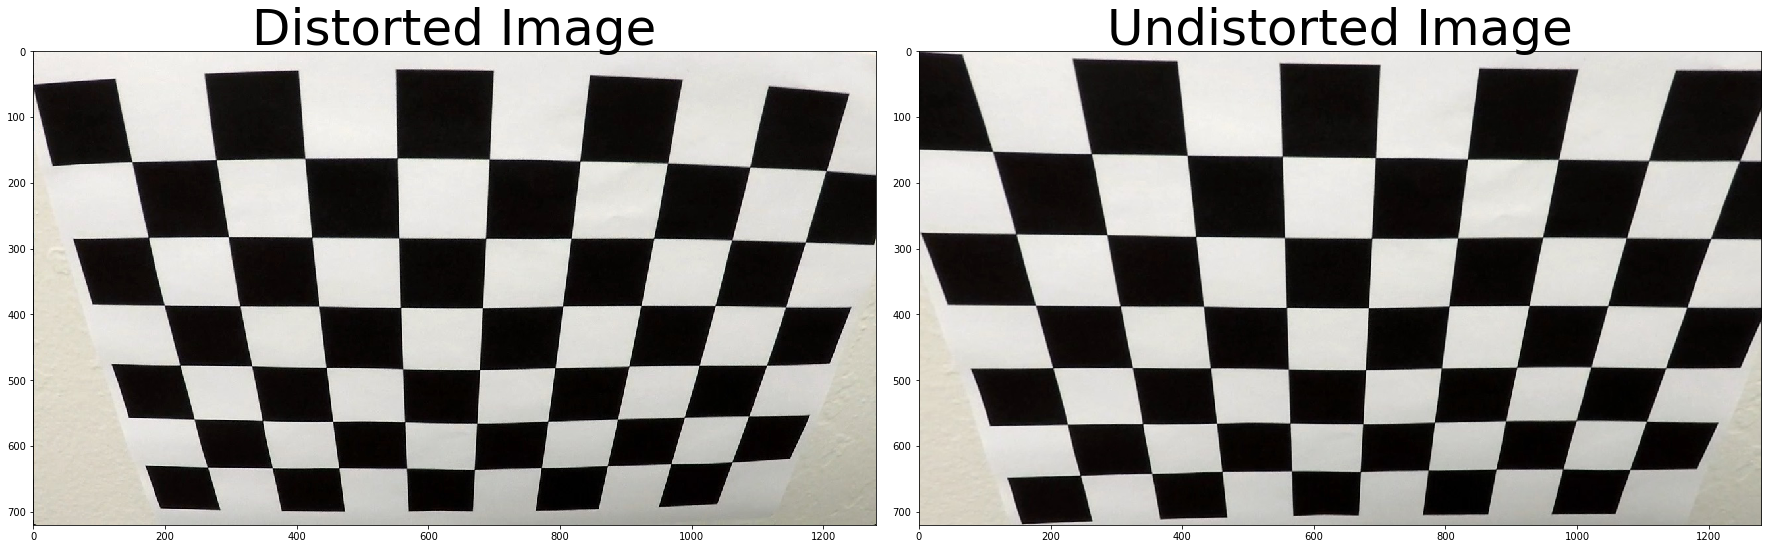

In [6]:
distorted_image = cv2.imread('camera_cal/calibration2.jpg')
distorted_image = cv2.cvtColor(distorted_image,cv2.COLOR_BGR2RGB)
mtx,dist = calibration(distorted_image,objpoints,imgpoints)
undistorted_image = distortion_correction(distorted_image,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_image)
ax1.set_title('Distorted Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient and Color transforms

Let's visualize an image in RGB channels and HLS channels.

In [7]:
def convert_to_hls(image):
    '''
    Input: RGB image
    Output: image converted to HLS color space
    '''
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

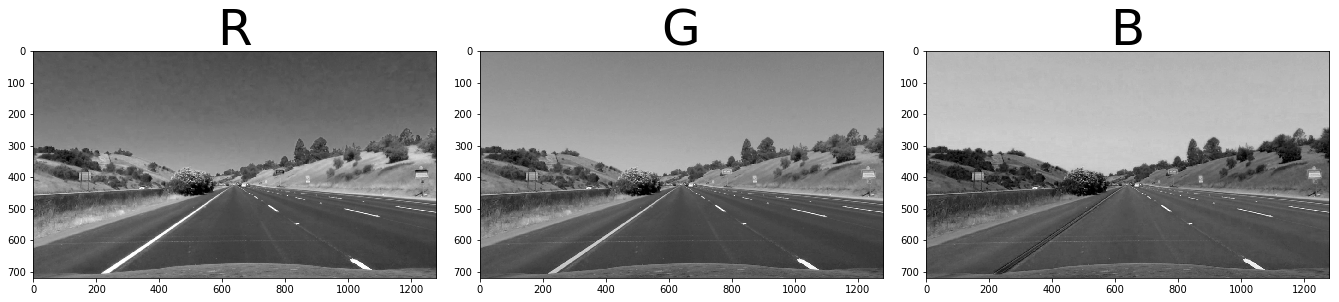

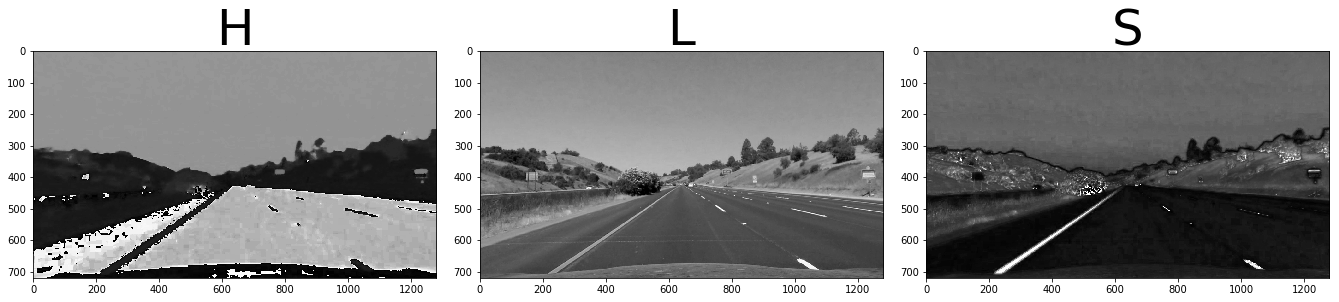

In [8]:
distorted_image = cv2.imread('test_images/straight_lines1.jpg')
distorted_image = cv2.cvtColor(distorted_image,cv2.COLOR_BGR2RGB)
mtx,dist = calibration(distorted_image,objpoints,imgpoints)
undistorted_image = distortion_correction(distorted_image,mtx,dist)
hls = convert_to_hls(undistorted_image)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

R = undistorted_image[:,:,0]
G = undistorted_image[:,:,1]
B = undistorted_image[:,:,2]

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 9))
f.tight_layout()
ax1.imshow(R,cmap='gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(G,cmap='gray')
ax2.set_title('G', fontsize=50)
ax3.imshow(B,cmap='gray')
ax3.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 9))
f.tight_layout()
ax1.imshow(H,cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L,cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S,cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

The lane lines from the S channel stand out very clearly. I will be using a combination of S and R channel to create a binary image.Lets apply a color threshold on R and S channel and see the output.

In [9]:
def get_binary(image,thresh = (15, 100)):
    '''
    Returns a binary image of a given image whose pixel values range between the given threshold
    '''
    binary = np.zeros_like(image)
    binary[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary

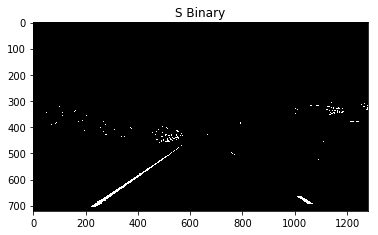

In [10]:
binary_s = get_binary(S,thresh = (170, 255))
plt.imshow(binary_s,cmap='gray')
plt.title('S Binary')
plt.show()

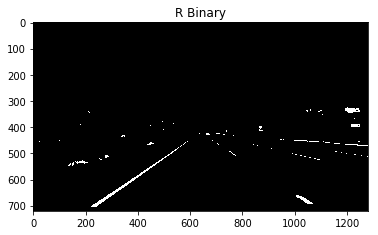

In [11]:
binary_r = get_binary(R,thresh = (200, 255))
plt.imshow(binary_r,cmap='gray')
plt.title('R Binary')
plt.show()

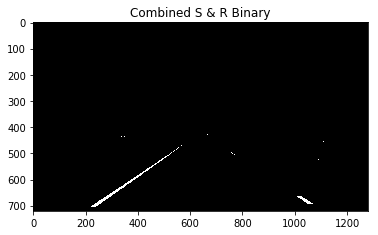

In [12]:
combined_sr = np.zeros_like(binary_r)
combined_sr[(binary_r==1) & (binary_s==1)] = 1
plt.imshow(combined_sr,cmap='gray')
plt.title('Combined S & R Binary')
plt.show()

Here the lane lines are standing out but it may not be the same case when there is a different lightning condition or the color of lane line has become dull. So i have decided to use a combination of color and gradient threshold(x grad, y grad, absolute grad and direction grad).After experimenting with the threshold values i found the threshold values: `(30,100) for grad x` , `(50,100) for grad y`, 
`(30,100) for magnitude grad` and `(0.8,1.2) for direction grad` and a `kernel size of 3` to work fine for this project.

In [13]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
    
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

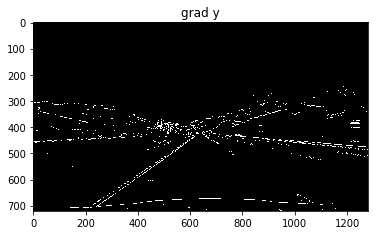

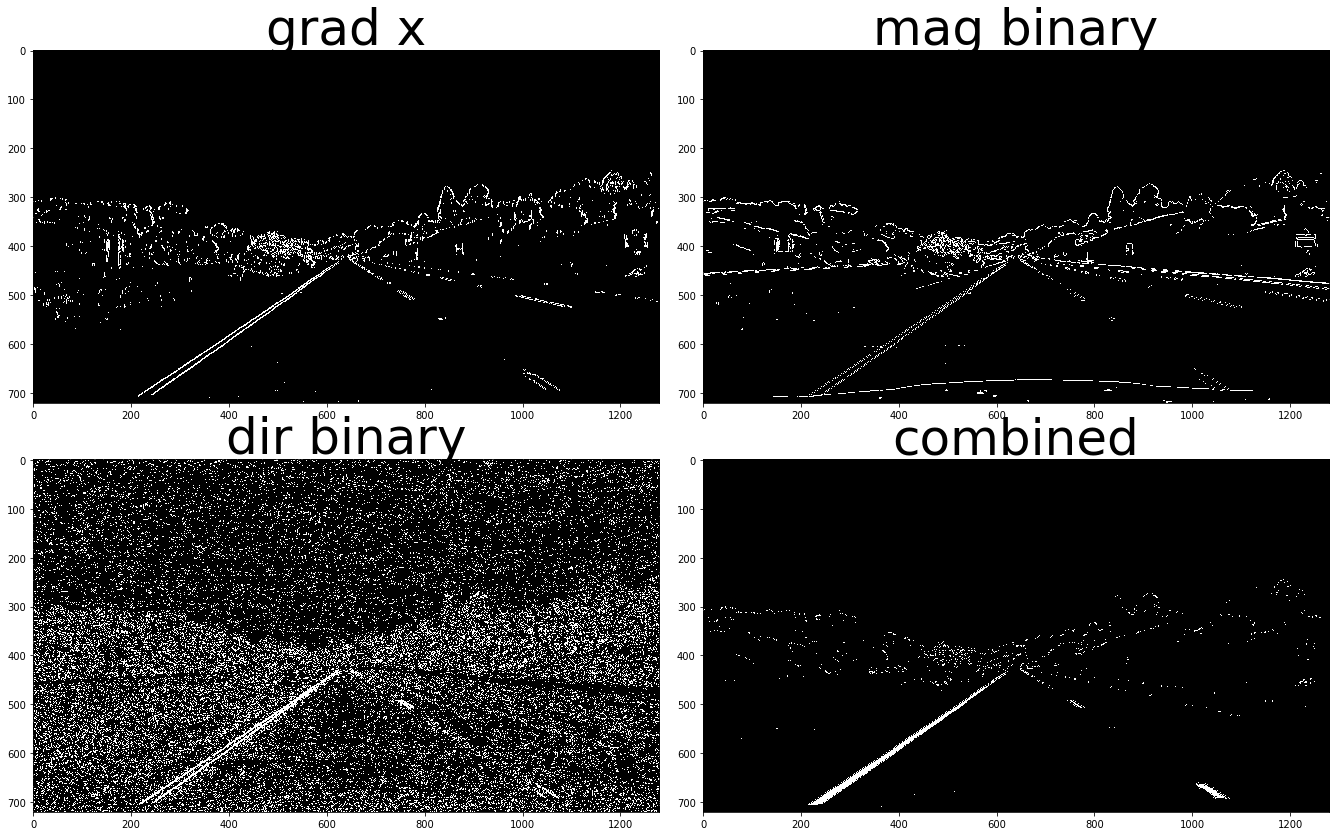

In [14]:
ksize = 3
try_image = undistorted_image.copy()
gradx = abs_sobel_thresh(try_image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(try_image, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_thresh(try_image, sobel_kernel=ksize, mag_thresh=(50, 100))
dir_binary = dir_threshold(try_image, sobel_kernel=ksize, thresh=(0.8, 1.2)) #thresh=(0.7, 1.3)
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | combined_sr==1] = 1

plt.imshow(grady,cmap='gray')
plt.title('grad y')
plt.show()
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(gradx,cmap='gray')
ax1.set_title('grad x', fontsize=50)
ax2.imshow(mag_binary,cmap='gray')
ax2.set_title('mag binary', fontsize=50)
ax3.imshow(dir_binary,cmap='gray')
ax3.set_title('dir binary', fontsize=50)
ax4.imshow(combined,cmap='gray')
ax4.set_title('combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.2, bottom=0.)


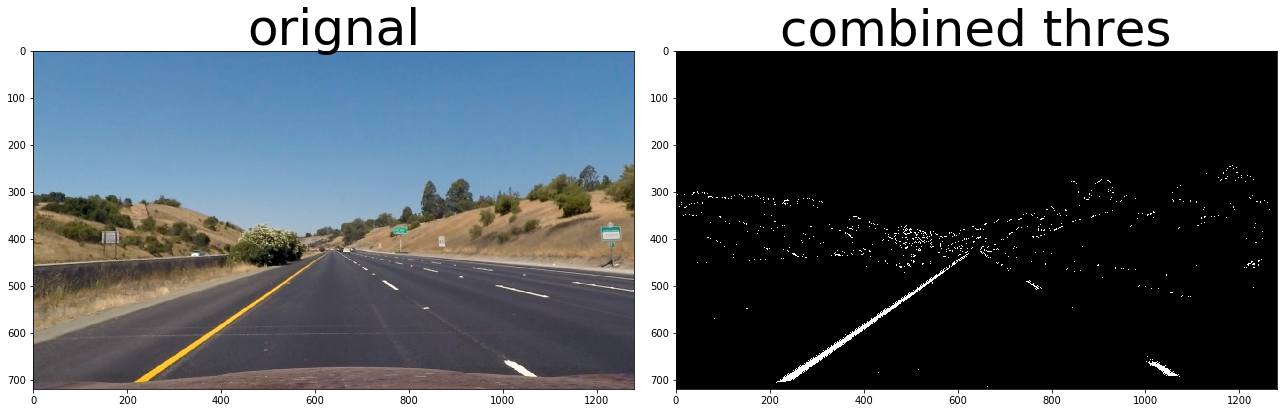

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(undistorted_image,cmap='gray')
ax1.set_title('orignal', fontsize=50)
ax2.imshow(combined,cmap='gray')
ax2.set_title('combined thres', fontsize=50)

### Perspective Transform

I choose the 4 source points and the destination points intutively by forming a polygon on the lanes.After many trail and error i decided to choose these source and destination points as they yielded good results.

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 573, 474      | 400, 100      | 
| 750, 475      | 1050, 100     |
| 1087, 676     | 1087, 720     |
| 300, 677      | 300, 720      |
The polygon with these vertices is drawn on the image for visualization. Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.


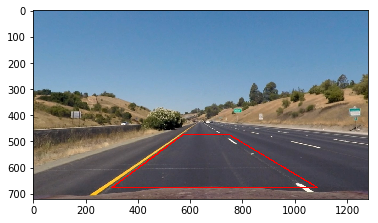

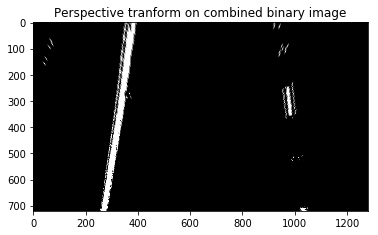

In [16]:
pts = np.array([[573,474],[750,475],[1087,676],[300,677]], np.int32)
pts = pts.reshape((-1,1,2))
undis_copy = undistorted_image.copy()
cv2.polylines(undis_copy,[pts],True,(255,0,0), thickness=3)
plt.imshow(undis_copy)
plt.show()

src = np.float32([[573,474],[750,475],[1087,676],[300,677]])
dest = np.float32([[400,100],[1050,100],[1087,720],[300,720]])
M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest,src)#undistorted_image   #combined
img_size = (combined.shape[1], combined.shape[0])
warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='gray')
plt.title('Perspective tranform on combined binary image')
plt.show()


## Finding the lane pixels

From the plot of histogram we can guess where the lanes are.We can guess from the peaks of the histogram where the lanes will be because after thresholding and warping there will be maximum pixels on the position of lanes.
We can find a midpoint of the image and search for peaks on left and right of the midpoint to find the base positions of left and right lanes. From the base points I use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.
I have used 9 windows of height 80 pixels.

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates to draw the lane lines.

In [17]:
def find_lines(binary_warped,testing=False):
    '''
    This function accepts a binary_warped image(perspective transformed) and returns 
    arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines
    '''
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if testing:
        plt.plot(histogram)
        plt.show()
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if testing:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return ploty,left_fitx,right_fitx

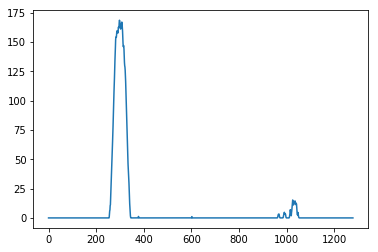

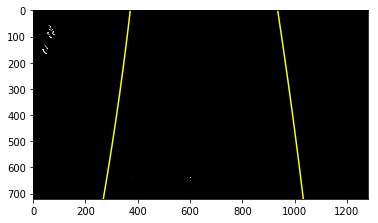

In [18]:
p,l,r = find_lines(warped,testing=True)

### Calculating radius of curvature of the lane and the position of the vehicle with respect to center.

I am calculating the radius of curvature in meters by the method given in classroom material.A pixel to meter conversion is used and the fits are calculated again.

To find the position of vehicle with respect to center, the center of image gives the position of car and to find the center of the lane we can calculate mean of the lane pixels closest to the car.The difference between the two will give us the measure of how much the car is left/right of the center.The difference obtained will be in pixels we need to convert them into meters. The code to calculate car's position is present on line 48-52 in `mypipeline()`

In [19]:
def find_curvature_in_mtrs(ploty,left_fitx,right_fitx):
    '''
    This function takes input as ploty ,left and right lines x coordinates and retuns the left and right lane 
    curvature in meters.
    '''
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad,right_curverad


In [20]:
l_c,r_c = find_curvature_in_mtrs(p,l,r)
print('Radius of curvature',(l_c+r_c)/2)

number_rows_t = warped.shape[0]
lane_center_t = (r[number_rows_t-1] + l[number_rows_t-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_away_pixels_t = abs(640 - lane_center_t)
center_away_mtrs_t = xm_per_pix*center_away_pixels_t
print('Center offset ', center_away_mtrs_t,'m')

Radius of curvature 5794.876332311366
Center offset  0.05720668055097083 m


### Plotting the result back on the road

For this step i have used the code provided by Udacity. The inverese tranformation matrix which was created before will be used here.

In [21]:
def unwrap_and_plot_lines(warped,Minv,undistorted_image,ploty,left_fitx,right_fitx):
    '''
    Input params: binary warped image, Inverse transformation matrix,undistorted image,ploty,left fit and right fit
    Output: Line projected on orignal undistorted image with a transparent region in light green color.
    '''
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


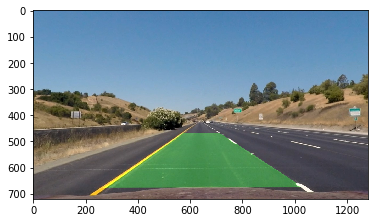

In [22]:
plt.imshow(unwrap_and_plot_lines(warped,Minv,undistorted_image,p,l,r))
plt.show()

## Pipeline

A pipeline named `mypipeline()` is created and an image is passed to it.The functions discussed above are called from this pipeline. The object points, image points for calibration along with camera matrix , distortion coefficients , tranformation matrix and inverse tranformation matrix are calulated before the pipeline because they will be same for all the images and recomputation will result in more processing time. 

Here's a [link to my video result](./project_video.mp4)

In [23]:
objpoints,imgpoints = get_imagepoints()
test_image = cv2.imread('test_images/test1.jpg')
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
mtx,dist = calibration(test_image,objpoints,imgpoints)
src = np.float32([[573,474],[750,475],[1087,676],[300,677]])
dest = np.float32([[400,100],[1050,100],[1087,720],[300,720]])
M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest,src)

In [24]:
def mypipeline(image):
    verbose = False
    #undistort image
    undistorted_image = distortion_correction(image,mtx,dist)
    #convert the image to hls channel from rgb
    hls = convert_to_hls(undistorted_image)
    #get the S channel
    S = hls[:,:,2]
    #apply a threshold and get binary image
    binary_s = get_binary(S,thresh = (170, 255))
    #get R channe;
    R = undistorted_image[:,:,0]
    #apply a threshold and get binary image
    binary_r = get_binary(R,thresh=(200,255))
    #combine binary R and S channel
    combined_sr = np.zeros_like(binary_r)
    combined_sr[(binary_r==1) & (binary_s==1)] = 1
    #selecting kernel size of 3 for applying sobel threshold
    ksize = 3
    try_image = undistorted_image.copy()
    #find x gradient
    gradx = abs_sobel_thresh(try_image, orient='x', sobel_kernel=ksize, thresh=(30, 100))#thresh=(20, 100)
    #find y gradient
    grady = abs_sobel_thresh(try_image, orient='y', sobel_kernel=ksize, thresh=(50, 100))#thresh=(30, 100)
    #find absolute gradient
    mag_binary = mag_thresh(try_image, sobel_kernel=ksize, mag_thresh=(50, 100))#mag_thresh=(30, 100)
    #find direction of gradient
    dir_binary = dir_threshold(try_image, sobel_kernel=ksize, thresh=(0.8, 1.2)) #thresh=(0.7, 1.3)
    combined = np.zeros_like(dir_binary)
    #combine all the gradx, grady, absolute gradient, direction gradient and SR binary
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | combined_sr==1 ] = 1
    img_size = (combined.shape[1], combined.shape[0])
    #perspective transform
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
    #find left and right lane lines
    ploty,left_fitx,right_fitx = find_lines(warped)
    #draw the line region on undistorted image
    output = unwrap_and_plot_lines(warped,Minv,undistorted_image,ploty,left_fitx,right_fitx)
    
    #find the left and right curvature in meters
    left_curvature, right_curvature = find_curvature_in_mtrs(ploty,left_fitx,right_fitx)
    
    #calculate the average of left and right curvature
    average_curvature = (left_curvature+right_curvature)/2
    string1 = "Radius of curvature: %.2f m" % average_curvature
    
    #calculate center offset
    number_rows = warped.shape[0]
    lane_center = (right_fitx[number_rows-1] + left_fitx[number_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_away_pixels = abs(img_size[0]/2 - lane_center)
    center_away_mtrs = xm_per_pix*center_away_pixels
    string2 = "Center offset: %.2f m" % center_away_mtrs
    
    cv2.putText(output,string1 , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(output, string2, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return output


In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
line_clip = clip1.fl_image(mypipeline)
%time line_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:05<00:00,  2.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

Wall time: 8min 7s


## Discussion

The pipeline works well for the project video but it fails for the challenge video.The pipeline stops with an error because no lane lines were detected.
In my current pipeline i have used combination of R & S channel but combination of R and G can be used to detect yellow lines along with S channel. L channel can be included to remove the edges generated due to shadows.

**Improvements:**

* If a bad frame is detected then values from previous frames can be used.
* Smoothing can be done to get a cleaner result.